# Week 11 - Introduction to Modeling, part 2

# 1. Lesson - No lesson this week

# 2. Weekly graph question

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

The book names one of Vonnegut's rules as "keep it simple" and another as "have the guts to cut."  Here is some data from the previous week's lesson.  If you had to cut one of the two plots below, which would it be?  Which seems more interesting or important?  Explain.  (Should "amount of training data used" or "number of estimators" be on the x-axis.)

In [3]:
np.random.seed(0)
num_points = 10000
feature_1a = np.random.random(size = num_points) * 3
feature_2a = np.random.random(size = num_points) * 3
feature_3a = np.random.random(size = num_points) * 3
train_target = (feature_1a - 2 * feature_2a) * feature_3a + np.random.normal(size = num_points)
feature_1b = np.random.random(size = num_points) * 3
feature_2b = np.random.random(size = num_points) * 3
feature_3b = np.random.random(size = num_points) * 3
test_target = (feature_1b - 2 * feature_2b) * feature_3b + np.random.normal(size = num_points)
train_df = pd.DataFrame({"f1": feature_1a, "f2": feature_2a, "f3": feature_3a})
test_df = pd.DataFrame({"f1": feature_1b, "f2": feature_2b, "f3": feature_3b})
rf = RandomForestRegressor()
rf.fit(train_df.values, train_target)

RandomForestRegressor()

In [ ]:
rmse_lst = list()
rf = RandomForestRegressor()
for x in range(round(num_points / 20), num_points, round(num_points / 20)):
    rf.fit(train_df.values[0:x,:], train_target[0:x])
    rmse_lst.append(root_mean_squared_error(rf.predict(test_df.values), test_target))

import matplotlib.pyplot as plt

Text(0, 0.5, 'Loss function')

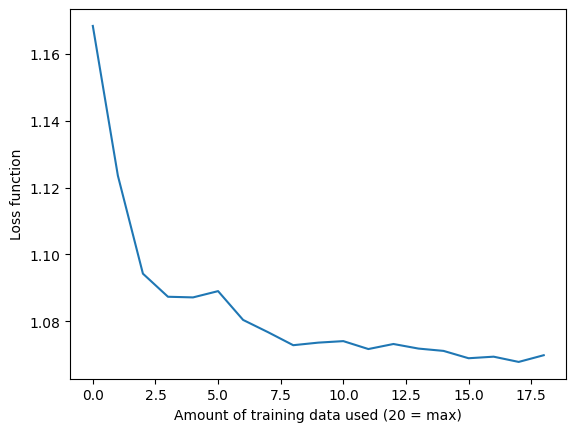

In [13]:
plt.plot(rmse_lst)
plt.xlabel("Amount of training data used (20 = max)")
plt.ylabel("Loss function")

In [14]:
num_trees_lst = list()
for n_estimators in range(1, 100, 3):
    rf = RandomForestRegressor(n_estimators = n_estimators)
    rf.fit(train_df.values, train_target)
    num_trees_lst.append(root_mean_squared_error(rf.predict(test_df.values), test_target))

Text(0, 0.5, 'Loss function')

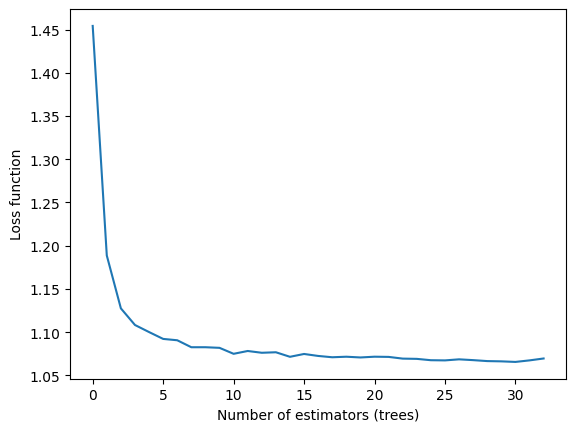

In [15]:
plt.plot(num_trees_lst)
plt.xlabel("Number of estimators (trees)")
plt.ylabel("Loss function")

Between the two graphs above, the first is likely to be more informational than the second. The first graph shows the amount of training data used and the improvement in the model's performance. This helps demonstrate how much training data is needed to reach a plateau or maximize performance.

The second graph also shows improvement in the model, but in relation to the number of trees added. This can be helpful when trying to find a parameter range that is effective but also practical in terms of computation time or resource usage.

Which one is more important depends on the goal of an analysis, however the first graph I would most likely keep as it shows the learning curve of the model and highlights how much of the data is actually used, while the second revloves more around the tuning of a single parameter.

# 3. Working on your datasets

This week, you will do the same types of exercises as last week, but you should use your own datasets that you found last semester.

Here are some types of analysis you can do:

* Implement a random forest model.
* Perform cross-validation.
* Tune hyperparameters.
* Evaluate a performance metric.

If you like, you can try other types of models, too (beyond linear regression and random forest) although you will have many opportunities to do that next semester.

In [4]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.metrics import classification_report, accuracy_score, make_scorer
from sklearn.preprocessing import LabelEncoder

In [5]:
UNSW_data = pd.read_csv("UNSW_NB15_training-set.csv", header=0)
UNSW_numeric_columns = [
    'dur', 'spkts', 'dpkts', 'sbytes', 'dbytes', 'sttl', 'dttl', 'sload', 
    'dload', 'sloss', 'dloss', 'sinpkt', 'dinpkt', 'sjit',	'djit',	'swin',	'stcpb',	
    'dtcpb', 'dwin', 'tcprtt', 'synack', 'ackdat', 'smean',	'dmean', 'trans_depth',	
    'response_body_len', 'ct_srv_src', 'ct_state_ttl', 'ct_dst_ltm', 'ct_src_dport_ltm',	
    'ct_dst_sport_ltm',	'ct_dst_src_ltm', 'ct_ftp_cmd', 'ct_flw_http_mthd',	'ct_src_ltm',
    'ct_srv_dst', 'rate' ]
for column in UNSW_data.columns:
    if column in UNSW_numeric_columns:
        UNSW_data[column] = UNSW_data[column].astype('int')
    else:
        UNSW_data[column] = UNSW_data[column].astype('category')

UNSW_data.head(10)

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0,udp,-,INT,2,0,496,0,90909,...,1,2,0,0,0,1,2,0,Normal,0
1,2,0,udp,-,INT,2,0,1762,0,125000,...,1,2,0,0,0,1,2,0,Normal,0
2,3,0,udp,-,INT,2,0,1068,0,200000,...,1,3,0,0,0,1,3,0,Normal,0
3,4,0,udp,-,INT,2,0,900,0,166666,...,1,3,0,0,0,2,3,0,Normal,0
4,5,0,udp,-,INT,2,0,2126,0,100000,...,1,3,0,0,0,2,3,0,Normal,0
5,6,0,udp,-,INT,2,0,784,0,333333,...,1,2,0,0,0,2,2,0,Normal,0
6,7,0,udp,-,INT,2,0,1960,0,166666,...,1,2,0,0,0,2,2,0,Normal,0
7,8,0,udp,-,INT,2,0,1384,0,35714,...,1,3,0,0,0,1,3,0,Normal,0
8,9,0,arp,-,INT,1,0,46,0,0,...,2,2,0,0,0,2,2,1,Normal,0
9,10,0,arp,-,INT,1,0,46,0,0,...,2,2,0,0,0,2,2,1,Normal,0


In [9]:
# target features
X = UNSW_data[UNSW_numeric_columns]
y = UNSW_data['label']  # classification target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # split

rf = RandomForestClassifier(random_state=42)
param_dist = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

random_search = RandomizedSearchCV(
    rf, param_distributions=param_dist,
    n_iter=20, cv=5, scoring='accuracy',
    random_state=42, n_jobs=-1
)

random_search.fit(X_train, y_train)

best_rf = random_search.best_estimator_
y_pred = best_rf.predict(X_test)

print("Best Parameters:", random_search.best_params_)


Best Parameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 30}


In [10]:
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Accuracy Score:", accuracy_score(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.98      0.98      7418
           1       0.99      0.98      0.98      9049

    accuracy                           0.98     16467
   macro avg       0.98      0.98      0.98     16467
weighted avg       0.98      0.98      0.98     16467

Accuracy Score: 0.9792311896520314


In [11]:
X = UNSW_data[UNSW_numeric_columns]
y = UNSW_data['attack_cat']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # split

rf = RandomForestClassifier(random_state=42)
param_dist = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

random_search = RandomizedSearchCV(
    rf, param_distributions=param_dist,
    n_iter=20, cv=5, scoring='accuracy',
    random_state=42, n_jobs=-1
)

random_search.fit(X_train, y_train)

best_rf = random_search.best_estimator_
y_pred = best_rf.predict(X_test)

print("Best Parameters:", random_search.best_params_)

Best Parameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 30}


In [12]:
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Accuracy Score:", accuracy_score(y_test, y_pred))

Classification Report:
                 precision    recall  f1-score   support

      Analysis       0.48      0.08      0.13       131
      Backdoor       0.07      0.01      0.02       117
           DoS       0.41      0.43      0.42       786
      Exploits       0.68      0.72      0.70      2275
       Fuzzers       0.70      0.70      0.70      1212
       Generic       1.00      0.98      0.99      3723
        Normal       0.96      0.99      0.98      7418
Reconnaissance       0.94      0.79      0.86       723
     Shellcode       0.55      0.53      0.54        75
         Worms       0.33      0.14      0.20         7

      accuracy                           0.88     16467
     macro avg       0.61      0.54      0.55     16467
  weighted avg       0.87      0.88      0.87     16467

Accuracy Score: 0.8764802331936601


# 4. Storytelling With Data plot

Reproduce any graph of your choice in chapter seven (p. 165-185) of the Storytelling With Data book as best you can. You do not have to get the exact data values right, just the overall look and feel.

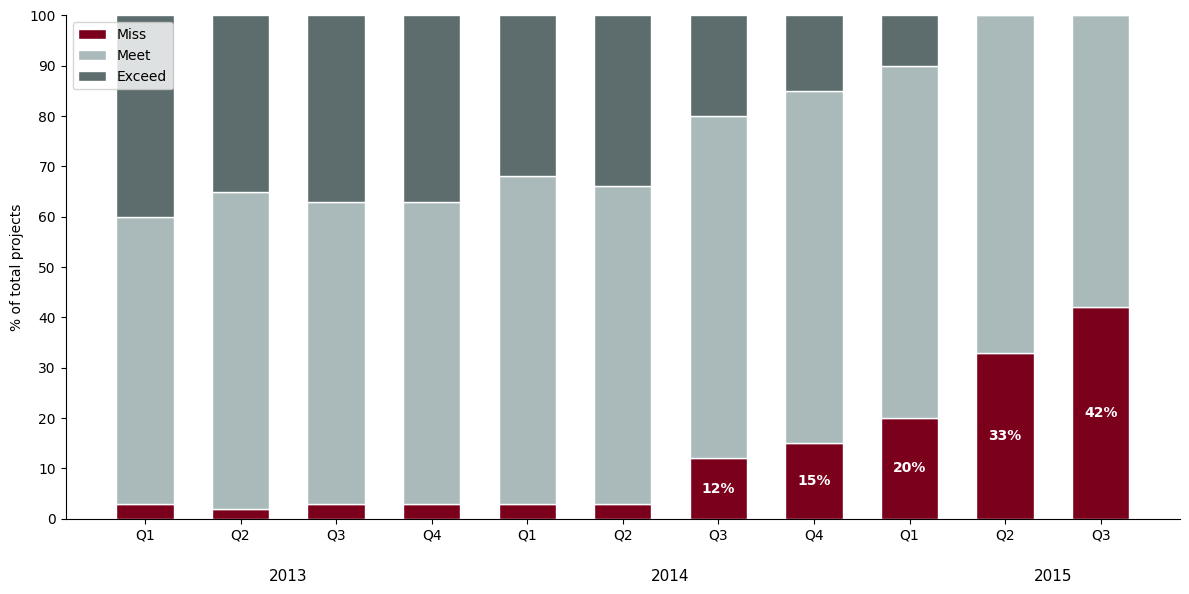

In [1]:
### GRAPH IS FROM WEEK 6

import numpy as np
import matplotlib.pyplot as plt

# data
labels = ['Q1', 'Q2', 'Q3', 'Q4'] * 2 + ['Q1', 'Q2', 'Q3']  # 11 total
years = ['2013'] * 4 + ['2014'] * 4 + ['2015'] * 3  # only 3 quarters in 2015

miss = [3, 2, 3, 3, 3, 3, 12, 15, 20, 33, 42]
meet = [57, 63, 60, 60, 65, 63, 68, 70, 70, 67, 58]
exceed = [40, 35, 37, 37, 32, 34, 20, 15, 10, 0, 0]

x = np.arange(len(miss))
width = 0.6
fig, ax = plt.subplots(figsize=(12, 6))

# stacked bars
p1 = ax.bar(x, miss, width, color='#7B001C', edgecolor="white", label='Miss')
p2 = ax.bar(x, meet, width, bottom=miss, color='#AABABB', edgecolor="white", label='Meet')
bottom_exceed = [miss[i] + meet[i] for i in range(len(miss))]
p3 = ax.bar(x, exceed, width, bottom=bottom_exceed, color='#5D6D6D', edgecolor="white", label='Exceed')

for i, val in enumerate(miss):
    if val >= 10:
        ax.text(x[i], val / 2, f"{val}%", ha='center', va='center', color='white', fontsize=10, fontweight='bold')

ax.set_ylabel('% of total projects')
ax.set_yticks(np.arange(0, 101, 10))
ax.set_ylim(0, 100)
ax.set_xticks(x)
ax.set_xticklabels(labels)
# Add secondary labels for years
for year_pos, year in zip([1.5, 5.5, 9.5], ['2013', '2014', '2015']):
    ax.text(year_pos, -10, year, ha='center', va='top', fontsize=11)

ax.spines[['top', 'right']].set_visible(False)
ax.legend(loc='upper left')
plt.tight_layout()
plt.show()